<a href="https://colab.research.google.com/github/aruaru0/pytorch-tests/blob/main/Metric_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.7 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=c9c838678e153644b3c6f951f3c282e094e9e37369e77fc69331b9ccbee10116
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

In [3]:
train_dataset = torchvision.datasets.MNIST(root="data", train=True, transform=torchvision.transforms.ToTensor(), download=True)
valid_dataset = torchvision.datasets.MNIST(root="data", train=False, transform=torchvision.transforms.ToTensor(), download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 78877373.15it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 64778445.90it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:03<00:00, 539535.81it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5681636.97it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



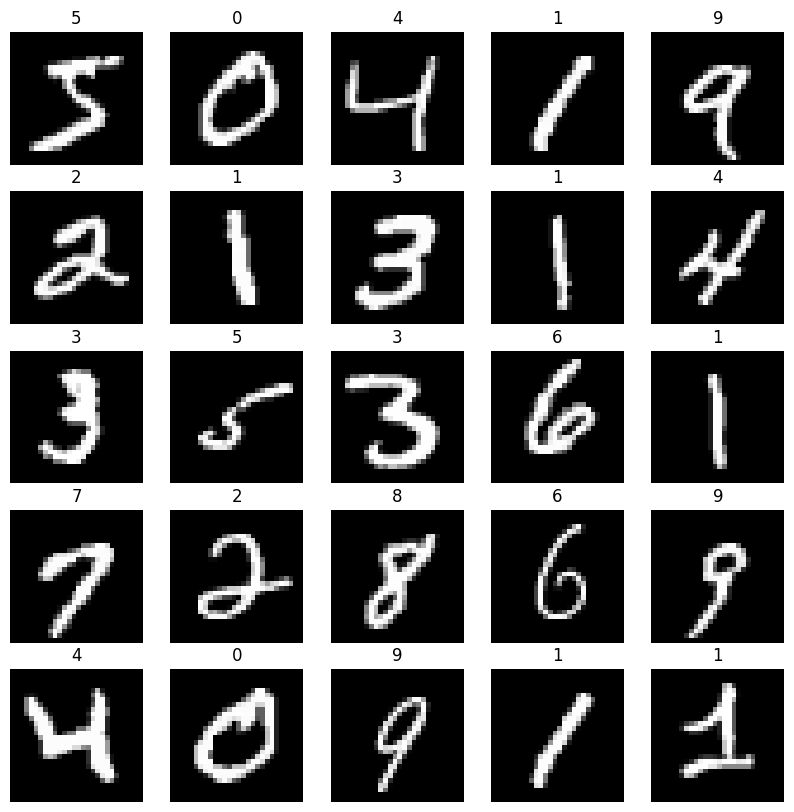

In [4]:
# データを確認
fig, ax = plt.subplots(5,5, figsize=(10,10))

for i in range(25) :
  img, label = train_dataset[i]
  r, c = i//5, i%5
  ax[r, c].imshow(img.squeeze(), cmap="gray")
  ax[r, c].axis("off")
  ax[r, c].set_title(label)


# データローダー

In [5]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# モデルの定義

In [6]:
class MyModel(nn.Module):
  def __init__(self, input_size):
    super(MyModel, self).__init__()
    self.size = input_size*input_size
    self.fc1 = nn.Linear(self.size, 1024)
    self.fc2 = nn.Linear(1024, 256)
    self.fc3 = nn.Linear(256, 10)
  def forward(self, x):
    x = x.view(-1, self.size)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MyModel(28).to(device)
model

MyModel(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
def do_train(model, device, loader, criterion, optimizer):
  model.train()
  tot_loss = 0.0
  tot_score = 0.0
  for images, labels in tqdm(loader, desc="train"):
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    tot_loss += loss.detach().item()
    tot_score += accuracy_score(labels.cpu(), outputs.argmax(dim=1).cpu())

  tot_loss /= len(loader)
  tot_score /= len(loader)
  return tot_loss, tot_score

def do_valid(model, device, loader, criterion):
  model.eval()
  tot_loss = 0.0
  tot_score = 0.0
  with torch.no_grad():
    for images, labels in tqdm(loader, desc="valid"):
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      tot_loss += loss.detach().item()
      tot_score += accuracy_score(labels.cpu(), outputs.argmax(dim=1).cpu())
  tot_loss /= len(loader)
  tot_score /= len(loader)
  return tot_loss, tot_score

In [10]:
num_epochs = 10
for epoch in range(num_epochs):
  print(f'[EPOCH {epoch+1}]')
  train_loss, train_acc = do_train(model, device, train_loader, criterion, optimizer)
  valid_loss, valid_acc = do_valid(model, device, valid_loader, criterion)
  print(f"--> train loss {train_loss}, train accuracy {train_acc}, valid loss {valid_loss} valid accuracy {valid_acc}")

[EPOCH 1]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.216414553754683, train accuracy 0.935617670575693, valid loss 0.09653676417137194 valid accuracy 0.96875
[EPOCH 2]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.08235150561811946, train accuracy 0.9737973081023454, valid loss 0.06709524311083014 valid accuracy 0.9790007961783439
[EPOCH 3]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.05357546438743521, train accuracy 0.9831256663113006, valid loss 0.06942104853351917 valid accuracy 0.9794984076433121
[EPOCH 4]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.039008634435272325, train accuracy 0.9872234808102346, valid loss 0.08099193130189755 valid accuracy 0.9748208598726115
[EPOCH 5]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.02832001369463395, train accuracy 0.9907382729211087, valid loss 0.06330930841767249 valid accuracy 0.9822850318471338
[EPOCH 6]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.02526972131401639, train accuracy 0.9915545042643923, valid loss 0.08698595549105251 valid accuracy 0.9773089171974523
[EPOCH 7]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.020502696237006193, train accuracy 0.9934868070362474, valid loss 0.07669700349512293 valid accuracy 0.9808917197452229
[EPOCH 8]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.017077719723159916, train accuracy 0.9942863805970149, valid loss 0.0777210346406232 valid accuracy 0.981687898089172
[EPOCH 9]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.015604263056866135, train accuracy 0.9946861673773987, valid loss 0.08688606867114142 valid accuracy 0.9806926751592356
[EPOCH 10]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.014326131248904268, train accuracy 0.9952192164179104, valid loss 0.10105971224019442 valid accuracy 0.9776074840764332


In [11]:
model.fc3 = nn.Identity()
model.eval()

features = None
classes  = None

for images, labels in tqdm(valid_loader):
  with torch.no_grad():
    images = images.to(device)
    outputs = model(images)
  # print(outputs.shape)
  if classes is None:
    classes = labels.cpu()
  else:
    classes = torch.cat((classes, labels.cpu()))

  if features is None:
    features = outputs.cpu()
  else:
    features = torch.cat((features, outputs.cpu()))

  0%|          | 0/157 [00:00<?, ?it/s]

In [12]:
features.shape, classes.shape

(torch.Size([10000, 256]), torch.Size([10000]))

In [13]:
%%time
import umap
umap = umap.UMAP(n_components=2, random_state=42)
X_umap = umap.fit_transform(features)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


CPU times: user 1min 5s, sys: 1.64 s, total: 1min 7s
Wall time: 1min 7s


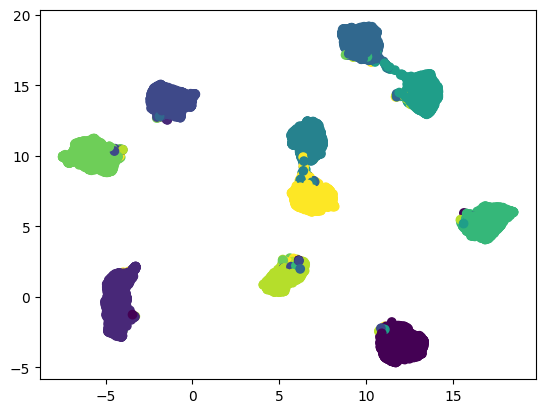

In [14]:
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=classes)
plt.show()

# Metric Learning

In [15]:
!pip install pytorch-metric-learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.6/118.6 kB 3.6 MB/s eta 0:00:00


In [16]:
from pytorch_metric_learning import losses

In [17]:
class MyModel(nn.Module):
  def __init__(self, input_size):
    super(MyModel, self).__init__()
    self.size = input_size*input_size
    self.fc1 = nn.Linear(self.size, 1024)
    self.fc2 = nn.Linear(1024, 256)
    # self.fc3 = nn.Linear(256, 256)
  def forward(self, x):
    x = x.view(-1, self.size)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    # x = self.fc3(x)
    return x

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MyModel(28).to(device)
model

MyModel(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
)

In [19]:
# import torchvision.models as models
# model = models.resnet18()

# model.conv1 = nn.Conv2d(
#     in_channels=1,
#     out_channels=64,
#     kernel_size=model.conv1.kernel_size,
#     stride=model.conv1.stride,
#     padding=model.conv1.padding,
#     bias=False
# )
# out_features=256
# model.fc = nn.Linear(in_features=512, out_features=out_features)
# model = model.to(device)

In [20]:
metric = losses.ArcFaceLoss(num_classes=10, embedding_size=256, scale=64, margin=32).to(device)
optimizer = torch.optim.Adam(
    [{'params': model.parameters()}, {'params': metric.parameters()}],
    lr=0.001)

In [21]:
def do_train(model, device, loader, criterion, optimizer):
  model.train()
  tot_loss = 0.0
  for images, labels in tqdm(loader, desc="train"):
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    tot_loss += loss.detach().item()

  tot_loss /= len(loader)
  return tot_loss

def do_valid(model, device, loader, criterion):
  model.eval()
  tot_loss = 0.0
  with torch.no_grad():
    for images, labels in tqdm(loader, desc="valid"):
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      tot_loss += loss.detach().item()
  tot_loss /= len(loader)
  return tot_loss

In [22]:
num_epochs = 10
for epoch in range(num_epochs):
  print(f'[EPOCH {epoch+1}]')
  train_loss = do_train(model, device, train_loader, metric, optimizer)
  valid_loss = do_valid(model, device, valid_loader, metric)
  print(f"--> train loss {train_loss}, valid loss {valid_loss}")

[EPOCH 1]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 4.9378290180978714, valid loss 2.632805617309656
[EPOCH 2]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 2.1011824907229957, valid loss 2.120444595654422
[EPOCH 3]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 1.5699038108285983, valid loss 2.0570586891382936
[EPOCH 4]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 1.262137568550998, valid loss 1.721772780391843
[EPOCH 5]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 1.0558323072924956, valid loss 1.6128438407709746
[EPOCH 6]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.9118298396895578, valid loss 1.6835638315170542
[EPOCH 7]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.8120292512797679, valid loss 1.5307809385722344
[EPOCH 8]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.6732938530986893, valid loss 1.7257426275562018
[EPOCH 9]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.6421248496310141, valid loss 1.573803060155798
[EPOCH 10]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.5427388029972096, valid loss 1.6027651342382263


In [23]:
model.eval()

features = None
classes  = None

for images, labels in tqdm(valid_loader):
  with torch.no_grad():
    images = images.to(device)
    outputs = model(images)
  # print(outputs.shape)
  if classes is None:
    classes = labels.cpu()
  else:
    classes = torch.cat((classes, labels.cpu()))

  if features is None:
    features = outputs.cpu()
  else:
    features = torch.cat((features, outputs.cpu()))

  0%|          | 0/157 [00:00<?, ?it/s]

In [24]:
features.shape, classes.shape

(torch.Size([10000, 256]), torch.Size([10000]))

In [25]:
%%time
import umap
umap = umap.UMAP(n_components=2, random_state=42)
X_umap = umap.fit_transform(features)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


CPU times: user 31.1 s, sys: 1.62 s, total: 32.8 s
Wall time: 44.8 s


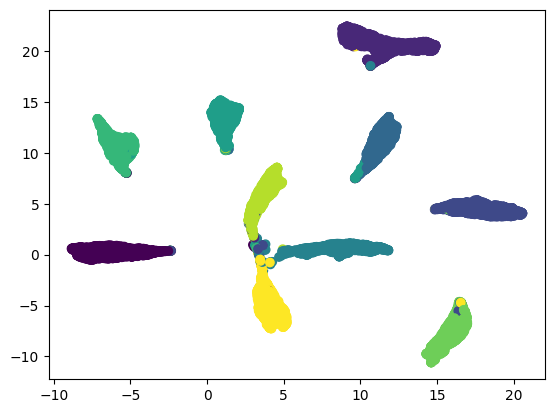

In [26]:
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=classes)
plt.show()

# 距離計算

In [27]:
images, labels = valid_loader.__iter__().__next__()

model.eval()
with torch.no_grad():
  images = images.to(device)
  features = model(images)

images.shape, labels.shape, features.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]), torch.Size([64, 256]))

In [28]:
from pytorch_metric_learning.distances import BatchedDistance, CosineSimilarity

def fn(mat, s, e):
    print(f"At query indices {s}:{e}")

distance = BatchedDistance(CosineSimilarity(), fn)

In [29]:
ret = CosineSimilarity()(features, features).cpu()

In [30]:
# 最初の文字とのコサイン距離が近いものを抽出する（閾値0.9）
print(f"label = {labels[0]}")
for i in range(64):
  if ret[0][i] > 0.9 :
    print("-"*40, end="")
  print(f"score = {float(ret[0][i]):.3f} label = {int(labels[i])}")

label = 7
----------------------------------------score = 1.000 label = 7
score = 0.003 label = 2
score = 0.012 label = 1
score = 0.000 label = 0
score = 0.003 label = 4
score = 0.008 label = 1
score = 0.001 label = 4
score = 0.000 label = 9
score = 0.000 label = 5
score = 0.003 label = 9
score = 0.004 label = 0
score = 0.056 label = 6
score = 0.000 label = 9
score = 0.012 label = 0
score = 0.038 label = 1
score = 0.000 label = 5
score = 0.000 label = 9
----------------------------------------score = 0.994 label = 7
score = 0.000 label = 3
score = 0.002 label = 4
score = 0.091 label = 9
score = 0.017 label = 6
score = 0.035 label = 6
score = 0.000 label = 5
score = 0.003 label = 4
score = 0.000 label = 0
----------------------------------------score = 0.979 label = 7
score = 0.003 label = 4
score = 0.006 label = 0
score = 0.049 label = 1
score = 0.000 label = 3
score = 0.051 label = 1
score = 0.000 label = 3
score = 0.021 label = 4
----------------------------------------score = 0.985 

# FAISSを使ってベクトル登録

In [31]:
!pip install faiss-cpu
# GPUを使う場合は
# !pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 59.0 MB/s eta 0:00:00


In [32]:
import faiss
import random

## INDEXを作成

In [33]:
dim = 256
nlist = 10
m = 32
nbits = 8

quantizer = faiss.IndexFlatL2(dim)
index = faiss.IndexIVFPQ(quantizer, dim, nlist, m, nbits)

In [34]:
# 訓練データの特徴量とラベルを全て抜き出す

model.eval()

features = None
classes  = None

for images, labels in tqdm(train_loader):
  with torch.no_grad():
    images = images.to(device)
    outputs = model(images)
  # print(outputs.shape)
  if classes is None:
    classes = labels.cpu()
  else:
    classes = torch.cat((classes, labels.cpu()))

  if features is None:
    features = outputs.cpu()
  else:
    features = torch.cat((features, outputs.cpu()))

  0%|          | 0/938 [00:00<?, ?it/s]

In [35]:
# 一部のデータで特徴量の分布を学習させる
train_data = np.array([v for v in features if random.random() < 0.01])
index.train(train_data)

In [36]:
# 10000毎に追加
batch_size = 10000
for i in range(0, len(classes), batch_size):
    input_vecs = []
    input_ids = []
    for item_id, vec in zip(classes[i:i+batch_size], features[i:i+batch_size]):
        input_vecs.append(vec)
        input_ids.append(item_id)
    input_vecs = np.array(input_vecs, dtype=np.float32)
    input_ids = np.array(input_ids, dtype=np.int64)
    index.add_with_ids(input_vecs, input_ids)

In [37]:
# 作成したインデックスを読み込む
faiss.write_index(index, "features.index")

## INDEXを利用

In [38]:
# インデックスを使って近傍検索を行う

# 検証データから最初の64個を取り出して特徴量を生成
images, labels = valid_loader.__iter__().__next__()
model.eval()
with torch.no_grad():
  images = images.to(device)
  features = model(images)

# 保存したインデックスを読み込む
index = faiss.read_index("features.index")

D, I = index.search(features.cpu().numpy(), 3) # 近傍３個を取得（D: distance, I: index）

for label, idx, dist in zip(labels, I, D):
  print(f"正解={label}, 検索結果(上位3位) = {idx}, 距離={dist}")

正解=7, 検索結果(上位3位) = [7 7 7], 距離=[0.8280258  0.83104515 0.83543587]
正解=2, 検索結果(上位3位) = [2 2 2], 距離=[2.2069016 2.3541641 2.628563 ]
正解=1, 検索結果(上位3位) = [1 1 1], 距離=[0.7098298  0.7652221  0.76621723]
正解=0, 検索結果(上位3位) = [0 0 0], 距離=[1.4807663 1.633812  1.8042068]
正解=4, 検索結果(上位3位) = [4 4 4], 距離=[1.3047619 1.8233051 1.8863115]
正解=1, 検索結果(上位3位) = [1 1 1], 距離=[0.6076369  0.6570759  0.65851307]
正解=4, 検索結果(上位3位) = [4 4 4], 距離=[1.2813187 1.4750557 1.5684624]
正解=9, 検索結果(上位3位) = [9 9 9], 距離=[0.4937954 0.5464635 0.6181474]
正解=5, 検索結果(上位3位) = [5 5 5], 距離=[1.4044724 1.5958595 1.6454773]
正解=9, 検索結果(上位3位) = [9 9 9], 距離=[0.50213623 0.5177002  0.77304745]
正解=0, 検索結果(上位3位) = [0 0 0], 距離=[1.3006096 1.6087284 1.6521225]
正解=6, 検索結果(上位3位) = [6 6 6], 距離=[3.3271904 3.9033127 3.943925 ]
正解=9, 検索結果(上位3位) = [9 9 9], 距離=[0.44005585 0.49206257 0.5001116 ]
正解=0, 検索結果(上位3位) = [0 0 0], 距離=[0.60485077 0.6452141  0.7530899 ]
正解=1, 検索結果(上位3位) = [1 1 1], 距離=[0.62160873 0.6259384  0.7224674 ]
正解=5, 検索結果(上位3位) = [5 5 5], 距離=[1.